# Graph Generation basato su attributi testuali
Obiettivo di questo notebook è quello di generare per ogni PA e Aggiudicatario una rappresentazione in uno spazio multidimensionale. Questa rappresentazione verrà usata per generare un grafo G(V,E) dove l'insieme dei nodi V rappresenta PA e Aggiudicatari, mentre l'insieme degli archi E definisce relazioni di similarità tra i nodi.

**Note**

Il dataset contiene 0 valori mancanti per il campo *cfStrutturaProponente* ed 8445 valori mancanti per il campo *cfPrimoaggiudicatario*. I valori mancanti verranno eliminati durante la fase di generazione dei documenti sintetici. Nonostante l'eliminazione di elementi con valori nulli, essendo il dataset molto sporco ci sono diversi  valori inconsistenti. Ad esempio ci sono stringhe formate da soli spazi o di sola punteggiatura speciale, stringhe non associate a reali p.iva o codici fiscali (e.g. "extra UE USA", "USA", "USA00004215"). Per fare ricerche basate su sottostringhe esegui il comando: 

``` python
example_df = df[pd.notnull(df['cfPrimoaggiudicatario'])]
example_df[example_df['cfPrimoaggiudicatario'].str.contains("USA|usa")==True]
```

Si definisce di seguito la soluzione proposta.


## Soluzione 1: creazione di vettori basati sul tf-idf

Ogni bando di gara è caratterizzato da un campo *oggetto*. Quindi per ogni elemento *i* ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad *i*.

A partire da D = {d<sub>i</sub> | i ∈ { PA ⋃  Fornitori}} è possibile creare la matrice W ∈ R<sup>(n,m)</sup>, ottenuta calcolando il TF-IDF su D.

In questo modo è possibile creare un grafo G_text(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(w<sub>u</sub>, w<sub>v</sub>)}  solo e soltanto se cos(w<sub>u</sub>, w<sub>v</sub>) >= *threshold*.

cos(w<sub>u</sub>, w<sub>v</sub>) ∈ [0,1], dove 0 implica che i documenti d<sub>u</sub>, d<sub>v</sub> sono completamente diversi, mentre 1 implica che i documenti hanno la stessa distribuzione di termini.


**Note**

- Dati i ∈ {PA} e j ∈ {Fornitori}, è possibile che se tutte le gare vinte da j riguardassero sempre i come struttura proponente (PA) e se tutte le gare di i siano vinte da j allora d<sub>i</sub> == d<sub>j</sub>, quindi cos(w<sub>i</sub>, w<sub>j</sub>) = 1.

- E’ possibile aggiungere al grafo G<sub>text</sub> nuovi nodi come l’insieme delle provincie e regioni. In questo caso è possibile associare ad ogni provincia (regione) i un documento sintentico d_i ottenuto concatenando tutti gli oggetti delle PA che insistono su i.  

- La matrice W non gestisce casi si sinonimia e polisemia (problema risolto con la soluziione successiva);

## Soluzione 2: creazione di vettori basati su word embedding dei top term pesati per il loro tf-idf

   Come nel precedente caso per ogni elemento i ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad i. 

Sia *L* l’insieme delle top n ∈ N parole più frequenti (in termine di tf-idf)  e *D* = {d’<sub>i</sub> | i ∈ { PA ⋃  Fornitori } }, dove d’<sub>i</sub> = {(l, w) | l ∈ L e w = TF-IDF(l, d<sub>i</sub>)}. 

In questo modo per ogni i è possibile costruire un vettore v<sub>i</sub>  dato dalla somma pesata degli embedding dei termini l contenuti in d’<sub>i</sub>. 
Per esempio, sia  L = [“fattura”, “acquisto”, “fornitura”] l’insieme dei top 3 termini in D, e sia D ={d<sub>1</sub>, d<sub>2</sub>, d<sub>3</sub>}, dove:

- d<sub>1</sub> = [(“acquisto”: w(1,acquisto)), (“fattura”: w(1,fattura))]  
- d<sub>2</sub> = [(“fattura”: w(2,fattura)), (“fornitura”: w(2,fornitura))]  
- d<sub>3</sub> = [(“acquisto”: w(3,acquisto)), (“fattura”: w(3,fattura)), (“fornitura”: w(3,fornitura))]

Quindi è possibile per ogni d<sub>i</sub> calcolare una rappresentazione vettoriale cosi definita:

 
embedding(d<sub>i</sub>) = $ \frac{1}{\sum_{wj∈di} wj} * \sum_{(tj,wj)∈di}$ w<sub>j</sub> * embedding(t<sub>j</sub>)
    
    
 

dove embedding(t<sub>j</sub>) è l’embedding del termine t<sub>j</sub> appreso su Wikipedia (vedi [qui](https://fasttext.cc/docs/en/support.html) per maggiori dettagli).

In questo modo è possibile creare un grafo G<sub>text</sub>(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(v<sub>du</sub>, v<sub>dv</sub>)}  solo e soltanto se cos(v<sub>du</sub>, v<sub>dv</sub>) >= threshold.



## Soluzione 3: creazione di vettori basati su word embedding dei top term 

   Questa soluzione è molto simile alla precedente. Tuttavia in questa soluzione tutti i termini contribuiscono in ugual misura all'embedding del documento. 
   
   In questo modo è possibile rappresentare d<sub>i</sub> come il centroide dei suoi termini:

 embedding(d<sub>i</sub>) = $ \frac{1}{\{tj | tj∈di\}} * \sum_{tj ∈ di}$ embedding(t<sub>j</sub>)
 
 
## Future Works

1. Al fine di discriminare maggiormente i documenti, si possono analizzare non sono parole di lunghezza 1, ma anche n-grammi (in questo modo documenti come {"fattura luce", "fattura telefono"} risultano meno simili )

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [2]:
t = time()
#dir_ = "data/anac/"
dir_ = "data/final_data/raw_data/"
file = dir_ + "anac_consip_2017.pickle" 
df = pd.read_pickle(file)

#df['cfPrimoaggiudicatario'] = df['cfPrimoaggiudicatario'].apply(str)

total = time() - t
    
print("Loading dataframe done in %0.3f sec" %  total)
df.info(memory_usage='deep')

Loading dataframe done in 1.056 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 960208 entries, 0 to 960207
Data columns (total 36 columns):
cig                                  958742 non-null object
cfStrutturaProponente                960208 non-null object
denominazioneStrutturaProponente     959088 non-null object
oggetto                              960208 non-null object
sceltaContraente                     960208 non-null object
importoAggiudicazione                960206 non-null float64
importoSommeLiquidate                960208 non-null float64
dataInizio                           960208 non-null datetime64[ns]
dataUltimazione                      852008 non-null datetime64[ns]
jsonPartecipanti                     960208 non-null object
jsonAggiudicatari                    960208 non-null object
totalePartecipanti                   960208 non-null int64
totaleAggiudicatari                  960208 non-null int64
totaleRaggruppamentopartecipanti     960208 non-null int6

In [3]:
#elimino tutti i codici fiscali palesemente errati
df = df[df.cfPrimoaggiudicatario.apply(lambda x:  len(set([c for c in str(x)])) > 1)]

## Creazione dei documenti sintetici d<sub>i</sub>

In questa sezione, per ogni attributo in *columns_to_aggregate*, è calcolato il suo documento sintetico 

In [4]:
#columns_to_aggregate = {("cfStrutturaProponente","PA"), ("cfPrimoaggiudicatario","AGG")}
columns_to_aggregate = {("cfPrimoaggiudicatario","AGG")}

aggregate_df = textual_analysis.createSyntheticDF(df, columns_to_aggregate)

aggregate_df.shape

Aggregation of attribute cfPrimoaggiudicatario done in 4.755 sec


(61059, 3)

In [5]:
f_consip = "data/consip/fornitori.pickle"

df_consip = pd.read_pickle(f_consip)

In [6]:
aggregate_df = pd.merge(aggregate_df, df_consip, left_on='codiceFiscaleStruttura', right_on='#Partita_Iva')

In [7]:
t = time()
file_name = "data/final_data/n6/oggetti_aggregati.pickle"
aggregate_df.to_pickle(file_name)
total = time() - t

print("Dataset stored in %0.3f sec" % total)

Dataset stored in 0.266 sec


In [8]:
## libera memoria
#una volta lanciato questo comando verranno perse tutte le variabili inizializzate in precedenza
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Creazione Matrice TF-IDF

La matrice dei tf-idf verrà utilizzata per entrambe le soluzioni. Prima di generare la matrice, sono eseguite le seguenti attività di preprocessing:
- Tokenization;
- Eliminazione di stopword (e.g. di, a, dell, quell, etc. );
- Selezione di parole composte solo da lettere e di cardinalità maggiore di 2 (e.g. eliminazione di codici di fattura)
- Eliminazione termini con frequenza nella collezione inferiore del 60% (i.e. max_df < 0.6) 

Alla matrice dei tf-idf generata è applicala la norma L2.


Inoltre si visualizzano di seguito le top 40 parole in termini di tf-idf.

In [45]:
dir_ =  "data/final_data/n6/" 

In [10]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display


In [11]:
def plotRankingAllTerms(sorted_frequents_words, title):
    """frequents_words: list of frequents words. Type: tuple(str, numpy.int64)
       title
    """
    #most_frequents_words = sorted(sorted_frequents_words, key = lambda x: x[1], reverse=True)
    x, y = zip(*sorted_frequents_words) # unpack a list of pairs into two tuples

    fig = plt.figure()
    ax1 = fig.add_subplot(111)  # Create matplotlib axes
    ax1.set_title(title)
    ax1.plot(x, y)
    ax1.axes.get_xaxis().set_ticks([])
    #ax1.set_yscale('log')
    #plt.ylabel('avg tf-idf score (log scale)')
    plt.ylabel('avg tf-idf score')
    
    fig.tight_layout()
    plt.savefig(file_name, pad = 0) #png
    plt.clf

In [15]:

df_file_name = dir_ + "oggetti_aggregati.pickle"

t = time()
df = pd.read_pickle(df_file_name)
total = time() - t

print("Dataset loaded in %0.3f sec" % total)

df.info()

Dataset loaded in 0.100 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61059 entries, 0 to 61058
Data columns (total 15 columns):
codiceFiscaleStruttura     61059 non-null object
oggetto                    61059 non-null object
tipoStruttura              61059 non-null object
#Partita_Iva               61059 non-null object
Ragione_Sociale            61059 non-null object
Forma_Societaria           61053 non-null object
Nazione_Sede_legale        61059 non-null object
Regione_Sede_legale        61052 non-null object
Provincia_Sede_legale      61052 non-null object
Comune_Sede_legale         61052 non-null object
Indirizzo_Sede_legale      61057 non-null object
Numero_Aggiudicazioni      61059 non-null int64
Numero_Abilitazioni        61059 non-null int64
Numero_Transazioni         61059 non-null int64
Numero_Contratti_attivi    61059 non-null int64
dtypes: int64(4), object(11)
memory usage: 7.5+ MB


In [16]:
t = time()

matrix, tf = textual_analysis.get_TFIDFmatrix_vect(df.oggetto, False)

total = time() - t

print("TFIDF matrix done in %0.3f sec" % total)
print("Shape TFIDF matrix", matrix.shape)

TFIDF matrix done in 4.423 sec
Shape TFIDF matrix (61059, 21278)


In [17]:
import pickle
pickle.dump(tf, open(dir_ + "tf.pickle", "wb"))
import scipy
scipy.sparse.save_npz(dir_ + 'sparse_matrix_tfidf.npz', matrix)

### Plot termini più discriminativi e distribuzione di termini per documento

Si può osservare come la frequenza dei termini segue la [legge di Zipf](https://it.wikipedia.org/wiki/Legge_di_Zipf). Infatti è possibile identificare un ristretto numero di termini caratterizzati da un alto tf-idf (i.e. fattura, fornitura, acquisto, pagamento, etc.), mentre la quasi totalità dei termini è caratterizzata da un tf-idf prossimo allo zero (vedi Fig.1 e Fig.2). 

Inoltre, si nota che i documenti sintetici generati hanno, nella maggioranza dei casi, un numero di parole distinte compreso tra 6 e 21. 

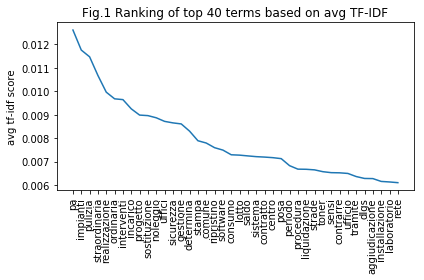

In [20]:
top_terms = 40

#Tf-Idf distribution
scores = zip(tf.get_feature_names(), np.asarray(matrix.mean(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
file_name = textual_analysis.plotTopNWords(sorted_scores, top_terms,  "Fig.1 Ranking of top "+ str(top_terms) + " terms based on avg TF-IDF")

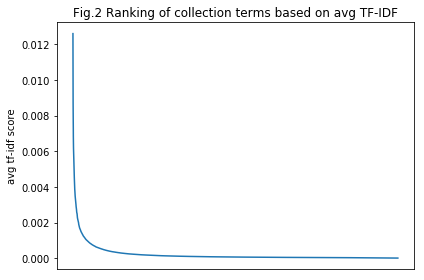

In [21]:
plotRankingAllTerms(sorted_scores,  "Fig.2 Ranking of collection terms based on avg TF-IDF")

In [22]:
rows = (matrix != 0).sum(1)
values = np.squeeze(np.asarray(rows))

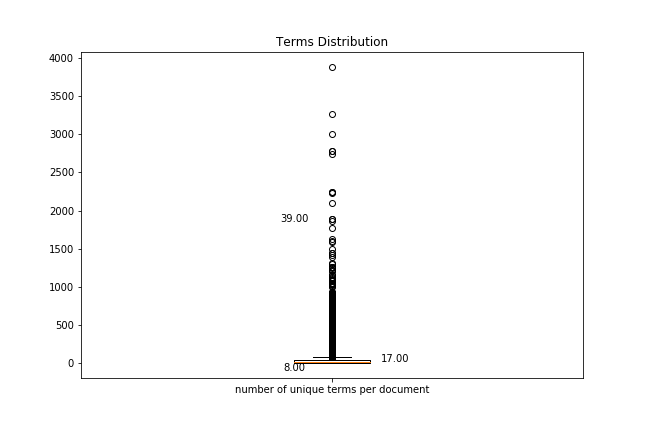

In [23]:
from pylab import text


# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(values)
plt.xticks([1], ["number of unique terms per document"])
plt.title("Terms Distribution")


for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x + 0.05, y, '%.2f' % y, horizontalalignment='center') # draw above, centered

for line in bp['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    text(x,y , '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below
    x, y = line.get_xydata()[3] # bottom of right line
    text(x, y*50, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below

f_img = "imgs/n6/term_distribution.png"    
plt.savefig(f_img)
plt.clf()
plt.close()


i = Image(f_img)
display(i)

In [24]:
#seleziona tutti i documenti aventi una rappresentazione tfidf composta di soli zero
pd.options.display.max_colwidth = 100
states = matrix.getnnz(1)== 0
row_indices = np.where(states)[0]
df.iloc[row_indices].head()

,codiceFiscaleStruttura,oggetto,tipoStruttura,#Partita_Iva,Ragione_Sociale,Forma_Societaria,Nazione_Sede_legale,Regione_Sede_legale,Provincia_Sede_legale,Comune_Sede_legale,Indirizzo_Sede_legale,Numero_Aggiudicazioni,Numero_Abilitazioni,Numero_Transazioni,Numero_Contratti_attivi
895,00139940324,fattura n 04e del 16122016,AGG,00139940324,GIEFFECI DI GRANDI PATRIZIA,Impresa Individuale,ITALIA,FRIULI VENEZIA GIULIA,TRIESTE,TRIESTE,STRADA VECCHIA DELL ISTRIA 116,0,2,0,1
1226,00169110996,pagamento fattura n36 del 24112017,AGG,00169110996,TIPOGRAFIA COLOMBO DI ELISABETTA BANCALARI & C. S.A.S.,Societ in Accomandita Semplice,ITALIA,LIGURIA,GENOVA,CHIAVARI,VIA NICOLA DALLORSO 10,0,2,1,1
1300,00174480830,pagamento fattura n2 del 23012017 pagamento fattura n3e del 10022017,AGG,00174480830,ABATE SCAFFALATURE S.R.L.,Societ a Responsabilit Limitata,ITALIA,SICILIA,MESSINA,MESSINA,"VIA LUIGI GALVANI, 12",0,7,1,1
1303,00174720334,affidamento tipograzia,AGG,00174720334,GRAFICHE LAMA SRL,Societ a Responsabilit Limitata,ITALIA,EMILIA ROMAGNA,PIACENZA,PIACENZA,STRADA AI DOSSI DI LE MOSE 5/7,0,1,1,1
1449,00187340997,manutenzione motovedetta,AGG,00187340997,TASSARA RICCARDO E C.SNC,Societ in Nome Collettivo,ITALIA,LIGURIA,GENOVA,RAPALLO,VIA SAN PIETRO 6,0,2,0,1


## Implementazione Soluzione 1

Questa implementazione consiste nella sola creazione della matrice tf-idf (salvata in *data/n6/sparse_matrix_tfidf.npz*).

Alla matrice sono state applicate tecniche di dimensionality reduction (i.e. SVD). Tuttavia si è osservato che risultati migliori si sono ottenuti con la sola matrice sparsa. So lascia di seguito la generazione della matrice densa ottenuta applicando SVD e normalizzazione (L2).

In [ ]:
#from sklearn.decomposition import TruncatedSVD
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import Normalizer

#t0 = time()
#svd = TruncatedSVD(300)
#normalizer = Normalizer(copy=False)
#preprocessing = make_pipeline(svd, normalizer).fit_transform(matrix)
#total = time() - t0
#print("Preprocessing done in done in %0.3f sec" % total)

#np.save("data/n6/matrix_tfidf", preprocessing)

## Implementazione Soluzione 2

In questa sezione verranno caricati i documenti sintetici salvati in *data/oggetti_aggregati.pickle* e per ogni elemento verrà generata una rappresentazione vettoriale basata su *FastText* (il file *cc.it.300.vec.gz* può essere scaricato [qui](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)). Come per l'implementazione della soluzione 1 verranno analizzati solo i top k termini piu frequenti (i.e. tutti i termini con document frequency > 10).

Output di questa fase saranno la matrice degli embedding (i.e. ) e la matrice degli embedding normalizzata per L2(i.e.)

In [ ]:
#il modello appreso da FastText richiede 10 GB di Ram. 
#Quindi potrebbe essere utile rilasciare tutta la memoria allocata e ricaricare solo i dati necessari
%reset

In [25]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [26]:
import pickle
tf = pickle.load(open(dir_ + "tf.pickle", "rb"))

import scipy
matrix = scipy.sparse.load_npz(dir_ +  'sparse_matrix_tfidf.npz')

In [27]:
from gensim.models import KeyedVectors
t0 = time()
jp_model = KeyedVectors.load_word2vec_format('data/fasttext/cc.it.300.vec.gz')

total = time() - t0
print("Fastext model loaded in %0.3f sec" % total)

Fastext model loaded in 398.603 sec


Si analizzano di seguito i termini frequenti presenti nella matrice-tfidf ma non presenti in FastText

In [28]:
not_present = []

t0 = time()
for term in tf.vocabulary_:
    if term not in jp_model.vocab:
            not_present.append(term)
total = time() - t0
print("Intersection done in %0.3f sec" % total)        

len_not_present = len(not_present) 
percentage = len_not_present / len(tf.vocabulary_) 
print("Percentage of absent terms: %0.2f (i.e. %d terms)" % (percentage, len_not_present)) 
print("Printing some term not present in Fastext model: ",not_present[:10])

Intersection done in 0.008 sec
Percentage of absent terms: 0.10 (i.e. 2082 terms)
Printing some term not present in Fastext model:  ['intercenter', 'taskalfa', 'fattn', 'sgiorgio', 'cigz', 'ecopf', 'sintel', 'materilae', 'comunaleditta', 'zbd']


In [34]:
t0 = time()
weighted = False
embedded_matrix = textual_analysis.calculate_embedding(tf, matrix, jp_model, matrix.shape[0], weighted)

total = time() - t0 
print("Embedding done in %0.3f sec" % total)

Embedding done in 73.450 sec


In [35]:
#check how many rows are all zero (it generates divisions by zero)
zero_rows = len(np.where(~embedded_matrix.any(axis=1))[0])
print("there are %d all zero rows" % zero_rows)

there are 459 all zero rows


In [36]:
t = len(tf.vocabulary_)
f = dir_ + "matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, embedded_matrix)

In [37]:
from sklearn.preprocessing import Normalizer
normalized_matrix = Normalizer(copy=False).fit_transform(embedded_matrix)
f = dir_ + "normalized_matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, normalized_matrix)

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/sklearn/utils/extmath.py:71: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(norms, norms)


In [40]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Generazione K nearest neighbors

Si generano di seguito i K nearest neighbors per ogni matrice generata (i.e. Soluzione 1,2 e 3).
In particolare per la matrice **sparsa** tf-idf si utilizzerà l'implementazione fornita da scikit-learn, mentre per le matrici **dense** degli embedding si utilizzerà la libreria *Faiss*.

### Generazione K nearest neighbors per la matrice tf-idf

In [41]:
k = 100

In [42]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [46]:
# matrice sparsa tfidf normalizzata con L2
import scipy.sparse
file_name = dir_ + "sparse_matrix_tfidf.npz"
matrix = scipy.sparse.load_npz(file_name)

In [47]:
t0 = time()
k = 100

I, D = textual_analysis.cosine_similarity_sparseMatrix(matrix, k, 1000)

total = time() - t0

print("K nearest neighbors done in %0.3f sec" % total)

Cosine similarity batch 0 done in 3.233 sec
Cosine similarity batch 1000 done in 3.558 sec
Cosine similarity batch 2000 done in 3.033 sec
Cosine similarity batch 3000 done in 3.116 sec
Cosine similarity batch 4000 done in 3.549 sec
Cosine similarity batch 5000 done in 3.401 sec
Cosine similarity batch 6000 done in 3.864 sec
Cosine similarity batch 7000 done in 3.630 sec
Cosine similarity batch 8000 done in 3.412 sec
Cosine similarity batch 9000 done in 3.294 sec
Cosine similarity batch 10000 done in 3.455 sec
Cosine similarity batch 11000 done in 3.563 sec
Cosine similarity batch 12000 done in 3.218 sec
Cosine similarity batch 13000 done in 3.104 sec
Cosine similarity batch 14000 done in 3.218 sec
Cosine similarity batch 15000 done in 3.129 sec
Cosine similarity batch 16000 done in 3.131 sec
Cosine similarity batch 17000 done in 3.240 sec
Cosine similarity batch 18000 done in 3.262 sec
Cosine similarity batch 19000 done in 3.249 sec
Cosine similarity batch 20000 done in 3.544 sec
Cosin

In [48]:
np.save(file_name + "similarity_D_" + str(k) + "_k", D)
np.save(file_name + "similarity_I_" + str(k) + "_k", I)

### Generazione K nearest neighbors per la matrice degli embedding

In [49]:
k = 100

In [55]:
#matrice densa embedding non pesata 
file_name = dir_ + "normalized_matrix_embedding_21278terms_weigthedFalse.npy"

#matrice densa embedding pesata con tfidf termini
#file_name = dir_ + "normalized_matrix_embedding_21278terms_weigthedTrue.npy"

matrix = np.load(file_name).astype('float32')

In [56]:
##check how many rows are all zero (it generates divisions by zero)
#zero_rows = len(np.where(~matrix.any(axis=1))[0])
#print("there are %d all zero rows" % zero_rows)

In [57]:
t0 = time()

I, D = textual_analysis.inner_product_denseMatrix(matrix, k)

total = time() - t0
print("Inner Product done in %0.3f sec" % total)

Train index:  True
Total elements to analyze:  61059
Inner Product done in 13.387 sec


In [58]:
np.save(file_name + "similarity_D_" + str(k) + "_k", D)
np.save(file_name + "similarity_I_" + str(k) + "_k", I)

### Confronto K nearest neighbors
Di seguito si confrontano i K nearest neighbors estratti attraverso le matrici calcolate in precedenza.

La matrice generata dai tf-idf (i.e. Soluzione 1) sfrutta correlazioni dirette tra termini. Ossia due documenti sono simili se condividono gli stessi termini. Le matrici generate a partire dagli embedding dei termini (i.e. Soluzione 2, Soluzione 3) invece codificano correlazioni indirette tra termini. In quest'ultimo caso, due documenti sono simili se condividono termini semanticamente simili (e.g. raccolta, rifiuti, smaltimento).  

Per verificare se le rappresentazioni estratte per ogni documento codificano le stesse informazioni, si analizza l'intersezione dei k documenti più simili sfruttando le 3 matrici generate:
- Matrice tf-idf
- Matrice embedding
- Matrice embedding pesata con tf-idf

Per ogni coppia di matrici m1,m2, se queste codificano le stesse informazioni, allora per ogni documento d_i:

  
intersection(get_most_similar(m1, i, k), get_most_similar(m2, i, k))  ~= k,

dove *get_most_similar(mj, i, k)* restituisce i k documenti più simili al documento di indice i utilizzando la matrice mj. 


In [60]:
I_embeddings_weighted = np.load(dir_ + "normalized_matrix_embedding_21278terms_weigthedTrue.npysimilarity_I_100_k.npy")
D_embeddings_weighted = np.load(dir_ + "normalized_matrix_embedding_21278terms_weigthedTrue.npysimilarity_D_100_k.npy")

I_embeddings = np.load(dir_ + "normalized_matrix_embedding_21278terms_weigthedFalse.npysimilarity_I_100_k.npy")
D_embeddings = np.load(dir_ + "normalized_matrix_embedding_21278terms_weigthedFalse.npysimilarity_D_100_k.npy")

I_tfidf = np.load(dir_ + "sparse_matrix_tfidf.npzsimilarity_I_100_k.npy")
D_tfidf = np.load(dir_ + "sparse_matrix_tfidf.npzsimilarity_D_100_k.npy")

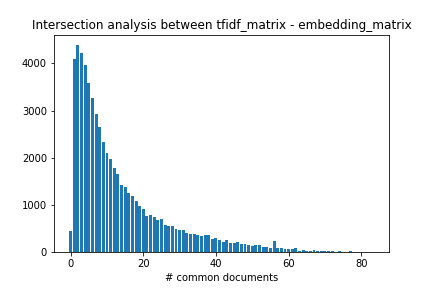

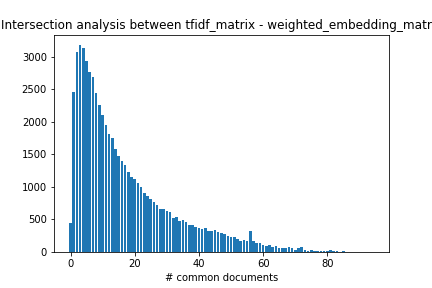

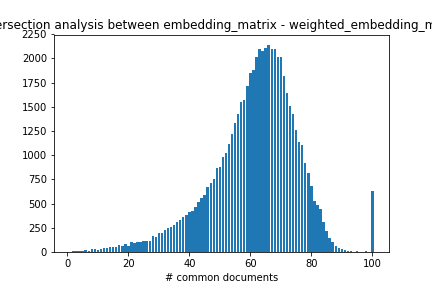

In [61]:
I_array = [I_tfidf, I_embeddings, I_embeddings_weighted]
k = len(I_embeddings[0])
labels = ["tfidf_matrix", "embedding_matrix", "weighted_embedding_matrix"]
intersection_array = []
str_labels = []

for i in range(len(I_array)):
    for j in range(i+1, len(I_array)):
    
        intersection = textual_analysis.get_intersection(I_array[i], I_array[j])
        intersection_array.append(intersection[:100000])
        title = "Intersection analysis between " + labels[i] + " - " + labels[j]
        f_img = "imgs/n6/intersection_"+ labels[i] + "." + labels[j] + "_k"+ str(k)+ ".png"
        str_labels.append(labels[i] + " vs " + labels[j])
        textual_analysis.bar_plot(pd.value_counts(intersection), title,f_img)

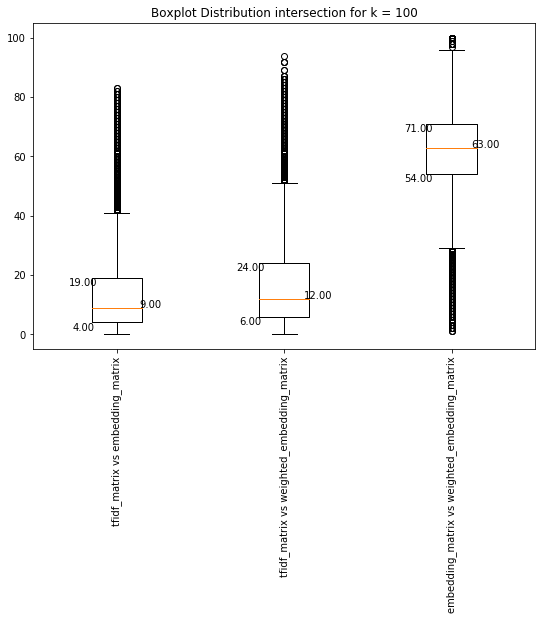

In [62]:
title = "Boxplot Distribution intersection for k = " + str(k)
filename = "imgs/n6/boxplot_comparisons_k"+ str(k)+ ".png"
       
textual_analysis.box_plot(intersection_array, str_labels, title, filename)

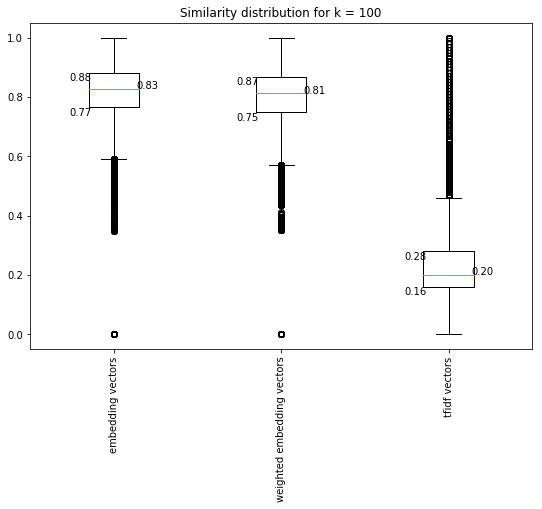

In [63]:
data_to_plot = [D_embeddings.ravel() [:100000], D_embeddings_weighted.ravel()[:100000],D_tfidf.ravel()[:100000]]
axis_labels = ['embedding vectors', 'weighted embedding vectors','tfidf vectors']
title = "Similarity distribution for k = "+ str(k)
filename = "imgs/n6/similarities_comparisons_k"+ str(k)+ ".png"
textual_analysis.box_plot(data_to_plot, axis_labels, title, filename)

### Visualizzazione dettaglio documenti strutture (i.e. Pa e Aggiudicatari) simili

Questa sezione permette di visualizzare in dettaglio i K nearest neighbors di un documento in input (utilizzando il suo indice di riga)
 

In [64]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [65]:

I_embeddings_weighted = np.load(dir_ + "normalized_matrix_embedding_21278terms_weigthedTrue.npysimilarity_I_100_k.npy")
D_embeddings_weighted = np.load(dir_ + "normalized_matrix_embedding_21278terms_weigthedTrue.npysimilarity_D_100_k.npy")

I_embeddings = np.load(dir_ + "normalized_matrix_embedding_21278terms_weigthedFalse.npysimilarity_I_100_k.npy")
D_embeddings = np.load(dir_ + "normalized_matrix_embedding_21278terms_weigthedFalse.npysimilarity_D_100_k.npy")

I_tfidf = np.load(dir_ + "sparse_matrix_tfidf.npzsimilarity_I_100_k.npy")
D_tfidf = np.load(dir_ + "sparse_matrix_tfidf.npzsimilarity_D_100_k.npy")

In [66]:
#per individuare la riga in funzione del codice fiscale esegui il seguente comando
#df.reset_index(inplace = True)
#df_aggregati[df_aggregati["codiceFiscaleStruttura"] == "01934490762"]

In [90]:
#scegli struttura da analizzare (scelta basata su indice di riga della matrice)
#per individuare la riga in funzione del codice fiscale esegui il seguente comando

iloc_document_to_compare = 6705#34088 #i.e. si sta analizzando la struttura 2226

I_matrix1 = I_tfidf
D_matrix1 = D_tfidf

#scegli la matrici da confrontare
I_matrix2 = I_embeddings_weighted
D_matrix2 = D_embeddings_weighted

In [91]:
file_name = dir_ + "oggetti_aggregati.pickle"

t0 = time()
df_aggregati = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

df_aggregati.info()

Dataset loaded in 0.078 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61059 entries, 0 to 61058
Data columns (total 15 columns):
codiceFiscaleStruttura     61059 non-null object
oggetto                    61059 non-null object
tipoStruttura              61059 non-null object
#Partita_Iva               61059 non-null object
Ragione_Sociale            61059 non-null object
Forma_Societaria           61053 non-null object
Nazione_Sede_legale        61059 non-null object
Regione_Sede_legale        61052 non-null object
Provincia_Sede_legale      61052 non-null object
Comune_Sede_legale         61052 non-null object
Indirizzo_Sede_legale      61057 non-null object
Numero_Aggiudicazioni      61059 non-null int64
Numero_Abilitazioni        61059 non-null int64
Numero_Transazioni         61059 non-null int64
Numero_Contratti_attivi    61059 non-null int64
dtypes: int64(4), object(11)
memory usage: 7.5+ MB


In [92]:
import pickle
tf = pickle.load(open(dir_ + "tf.pickle", "rb"))

import scipy
m = scipy.sparse.load_npz(dir_ + 'sparse_matrix_tfidf.npz')

In [93]:
pd.options.display.max_colwidth = 100
df_aggregati.iloc[[iloc_document_to_compare]]

,codiceFiscaleStruttura,oggetto,tipoStruttura,#Partita_Iva,Ragione_Sociale,Forma_Societaria,Nazione_Sede_legale,Regione_Sede_legale,Provincia_Sede_legale,Comune_Sede_legale,Indirizzo_Sede_legale,Numero_Aggiudicazioni,Numero_Abilitazioni,Numero_Transazioni,Numero_Contratti_attivi
6705,00823020250,affidamento incarico di redazione perizia geologicotecnica relativa al progetto di realizzazione...,AGG,00823020250,GEOL. ENNIO DA ROIT,Impresa Individuale,ITALIA,VENETO,BELLUNO,BELLUNO,VIA SAN LORENZO 26,0,1,0,0


In [94]:
commons_docs =  set(I_matrix1[iloc_document_to_compare]).intersection(set(I_matrix2[iloc_document_to_compare]))
df_most_similar = df_aggregati.iloc[list(commons_docs)]
df_most_similar["top_terms"] = textual_analysis.get_best_terms_frequencies(m, tf.get_feature_names(), commons_docs, 40)
df_most_similar.head()

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,codiceFiscaleStruttura,oggetto,tipoStruttura,#Partita_Iva,Ragione_Sociale,Forma_Societaria,Nazione_Sede_legale,Regione_Sede_legale,Provincia_Sede_legale,Comune_Sede_legale,Indirizzo_Sede_legale,Numero_Aggiudicazioni,Numero_Abilitazioni,Numero_Transazioni,Numero_Contratti_attivi,top_terms
31877,02418680308,completamento ed ampliamento sede allocamento e deposito squadra comunale di protezione cup e17...,AGG,02418680308,STUDIO DI ARCHITETTURA E INGEGNERIA RIGO,Professione organizzata (cfr. Art. 2229 cc),ITALIA,FRIULI VENEZIA GIULIA,UDINE,UDINE,VIA LIGURIA 325,0,1,0,0,progettazione:0.26 farfalle:0.23 professionale:0.22 definitivaesecutiva:0.21 incarico:0.21 riqua...
26093,02056950302,affidamento incarico professionale per la predisposizione della documentazione attestante lidone...,AGG,02056950302,MASSIMO VALENT GEOLOGO,Professione organizzata (cfr. Art. 2229 cc),ITALIA,FRIULI VENEZIA GIULIA,UDINE,MAGNANO IN RIVIERA,VIALE MARINELLI 23,0,1,0,0,geologica:0.40 relazione:0.25 vulnerabilit:0.24 redazione:0.22 finalizzata:0.20 strutturale:0.19...
1808,00227820420,incarico redazione progetto per eseguire i lavori di somma urgenza consistenti nella messa in si...,AGG,00227820420,ING. ARCH. FRANCO LUMINARI,Professione organizzata (cfr. Art. 2229 cc),ITALIA,MARCHE,ANCONA,JESI,"VIA ANCONA, 17 BIS",0,1,0,0,redazione:0.31 moie:0.26 frazione:0.26 professionale:0.24 campanile:0.23 consistenti:0.22 fattib...
6705,00823020250,affidamento incarico di redazione perizia geologicotecnica relativa al progetto di realizzazione...,AGG,00823020250,GEOL. ENNIO DA ROIT,Impresa Individuale,ITALIA,VENETO,BELLUNO,BELLUNO,VIA SAN LORENZO 26,0,1,0,0,forestale:0.45 perizia:0.41 valle:0.37 redazione:0.35 strada:0.33 relativa:0.33 incarico:0.23 pr...
20790,01735270389,sopralluogo per intervento di posizionamento arula e sabbiera presso il museo casa frabboni impe...,AGG,01735270389,PERIZIA SRL,Societ a Responsabilit Limitata,ITALIA,EMILIA ROMAGNA,FERRARA,FERRARA,VIA MODENA 5,0,1,0,0,redazione:0.29 compilazione:0.28 relazione:0.23 sabbiera:0.22 esaurita:0.22 stima:0.19 emissioni...


In [95]:
pd.options.display.max_colwidth = 1000
df_aggregati.iloc[[iloc_document_to_compare]].oggetto

6705    affidamento incarico di redazione perizia geologicotecnica relativa al progetto di realizzazione di una strada forestale in valle di angheraz
Name: oggetto, dtype: object

### K nearest neighbors using tf-idf

In [96]:
cols = ["Ragione_Sociale", "codiceFiscaleStruttura", "top_terms", "cosine_similarity"]

pd.options.display.max_colwidth = 500
best_docs = I_matrix1[iloc_document_to_compare]
matrix_docs = df_aggregati.iloc[best_docs]
matrix_docs["top_terms"] = textual_analysis.get_best_terms_frequencies(m, tf.get_feature_names(), best_docs, 20)
matrix_docs["cosine_similarity"] = D_matrix1[iloc_document_to_compare]
matrix_docs[cols]

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Ragione_Sociale,codiceFiscaleStruttura,top_terms,cosine_similarity
6705,GEOL. ENNIO DA ROIT,00823020250,forestale:0.45 perizia:0.41 valle:0.37 redazione:0.35 strada:0.33 relativa:0.33 incarico:0.23 progetto:0.23 realizzazione:0.23,1.00
30017,ANDRETTO MARIO E C. SNC DI ANDRETTO SERGIO,02295030247,perizia:1.00,0.41
29234,EQUA,02246380345,perizia:1.00,0.41
53348,TEMI,06415291001,redazione:0.73 incarico:0.49 determina:0.48,0.37
42413,GHIO EMANUELE,03474950049,forestale:0.83 attivita:0.56,0.37
45815,GEOLOGO DOMENICO NEGRO,03970660654,geologica:0.49 sub:0.42 irrigazione:0.38 perizia:0.37 conferimento:0.33 redazione:0.32 incarico:0.21 realizzazione:0.21,0.36
11294,POGGIO GIANLUCA,01168550059,strada:1.00,0.33
32595,STUDIO ASSOCIATO SILVANO & MAZZUCCO,02465330062,perizia:0.35 giurata:0.33 elaborato:0.32 ferrario:0.32 rivalutazione:0.31 alienazione:0.29 gm:0.25 urbanistica:0.23 recepimento:0.20 variante:0.20 incarico:0.20 redazione:0.18 professionale:0.17 edificio:0.17 relativa:0.16 ex:0.13 tecnico:0.13,0.30
10152,DESSI' ROSSELLA,01099180950,svincolo:0.58 strada:0.44 ales:0.32 provinciale:0.31 riguardante:0.26 realizzazione:0.24 perizia:0.21 variante:0.21 sp:0.17 completamento:0.16,0.29
58555,WILLIAM ROCA PROFESSIONE ORGANIZZATA,10348170019,alberature:0.55 perizia:0.52 proprieta:0.42 zd:0.40 incarico:0.30,0.28


### K nearest neighbors using embedding 

In [97]:
best_docs = I_matrix2[iloc_document_to_compare]
matrix_docs = df_aggregati.iloc[best_docs]
matrix_docs["top_terms"] = textual_analysis.get_best_terms_frequencies(m, tf.get_feature_names(), best_docs, 20)
matrix_docs["cosine_similarity"] = D_matrix2[iloc_document_to_compare]
matrix_docs[cols]

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Ragione_Sociale,codiceFiscaleStruttura,top_terms,cosine_similarity
6705,GEOL. ENNIO DA ROIT,00823020250,forestale:0.45 perizia:0.41 valle:0.37 redazione:0.35 strada:0.33 relativa:0.33 incarico:0.23 progetto:0.23 realizzazione:0.23,1.000000
39886,NETMOBILITY,03184140238,optlp:0.23 opk:0.23 alling:0.21 riso:0.20 strategica:0.20 lattuazione:0.20 validazione:0.19 agenda:0.19 coordinatore:0.18 sostenibile:0.18 riva:0.18 nuova:0.17 mobilit:0.17 ciclabile:0.16 traffico:0.16 esecutivo:0.16 esecutiva:0.15 dellincarico:0.15 francesco:0.15 direttore:0.15,0.814997
26093,MASSIMO VALENT GEOLOGO,02056950302,geologica:0.40 relazione:0.25 vulnerabilit:0.24 redazione:0.22 finalizzata:0.20 strutturale:0.19 tarcento:0.17 teor:0.17 miniera:0.16 rivignano:0.16 incarico:0.16 incluse:0.15 gemona:0.15 professionale:0.15 geologico:0.15 massi:0.14 carbone:0.14 propedeutiche:0.14 verifica:0.14 caduta:0.13,0.813565
25745,MELLO RELLA & ASSOCIATI - INGEGNERIA,02033900024,passerella:0.31 pedonale:0.24 adiacenza:0.21 redazione:0.21 tracciato:0.20 roggia:0.19 fattibilit:0.18 coordinatore:0.17 prossimit:0.17 incarico:0.17 attraversamento:0.17 raccordo:0.16 manufatti:0.16 tecnica:0.16 marciapiede:0.16 umbria:0.15 torrente:0.15 economica:0.15 contabilit:0.15 gioco:0.15,0.807283
1117,GAETTI COSTRUZIONI S.R.L.,00161870365,panaro:0.26 tombinatura:0.25 capoluogo:0.25 secchia:0.24 messa:0.24 parco:0.21 sicurezza:0.21 trattativa:0.20 adeguamento:0.20 diretta:0.19 natura:0.19 dopera:0.18 percorsi:0.18 asfaltatura:0.18 contabilita:0.18 costruzioni:0.17 finale:0.17 variante:0.17 localita:0.16 cavo:0.15,0.798681
57607,G.EDI.S. S.R.L.,09375331007,relazione:0.26 osta:0.25 nulla:0.25 torrione:0.24 lincarico:0.22 geologica:0.21 doria:0.20 drenaggio:0.19 testa:0.19 rimessa:0.18 intercomunale:0.18 casale:0.18 finalizzata:0.18 contenimento:0.17 esecutivo:0.17 efficienza:0.17 indagini:0.16 val:0.16 borgo:0.16 chiesa:0.16,0.798155
43941,TS SISTEMI DI TALLORU SALVATORE,03660090923,lautomazione:0.34 lorto:0.33 vetrina:0.30 espositiva:0.29 botanico:0.25 dappalto:0.24 ciclabile:0.24 ponti:0.24 cimiteriale:0.24 pista:0.22 perizia:0.22 indizione:0.21 radio:0.21 cancello:0.21 approvazione:0.15 opera:0.14 gara:0.14 posa:0.14,0.797092
29891,CAFISSI AVARO SRL UNIP,02287830976,torrente:0.24 dopera:0.19 tipo:0.18 variante:0.17 arginature:0.17 incidentale:0.16 variata:0.16 montemurlo:0.16 bisenzio:0.16 idrografico:0.15 signa:0.15 valdarno:0.15 reticolo:0.14 destra:0.14 civile:0.14 suppletiva:0.13 ordinaria:0.12 corso:0.12 bacino:0.12 medio:0.12,0.796048
14344,PROMOTER SRL,01361610338,irrigui:0.24 progettazione:0.22 laghi:0.21 esecutiva:0.18 valorizzazione:0.18 borgo:0.17 misura:0.17 incarico:0.17 ambientale:0.16 irrigue:0.16 medievale:0.15 lavor:0.15 arda:0.15 professionale:0.15 calcoli:0.15 direzione:0.15 strutture:0.14 dellaccordo:0.14 irriguo:0.13 psr:0.13,0.791402
31877,STUDIO DI ARCHITETTURA E INGEGNERIA RIGO,02418680308,progettazione:0.26 farfalle:0.23 professionale:0.22 definitivaesecutiva:0.21 incarico:0.21 riqualificazione:0.21 lespletamento:0.19 espositivo:0.19 statico:0.18 carattere:0.18 leonardo:0.17 vinci:0.17 zone:0.16 contabilit:0.16 energetica:0.16 squadra:0.16 pratica:0.15 perizia:0.15 variante:0.15 urbana:0.15,0.791032


## Creazione grafo Neo4j

Input:
- "oggetti_aggregati.pickle", file contenente le informazioni da associare ad un nodo;
- Matrici K nearest neighbors *I* e *D* (i.e. normalized_matrix_embedding_21278terms_weigthedTrue.npysimilarity_I_100_k.npy, normalized_matrix_embedding_21278terms_weigthedTrue.npysimilarity_D_100_k.npy)
- 'tf.pickle'
- 'sparse_matrix_tfidf.npz'


In particolare per ogni nodo vengono memorizzate le seguenti informazioni:

- type_id  (1 per PA, 0 per AGG);
- node_type = ('PA', 'AGG');
- id_s, indice di riga nel dataframe *oggetti_aggregati*;
- fiscal_code, codice fiscale / partita iva del nodo (feature 'codiceFiscaleStruttura');
- relevant_terms, stringa contenente i top term rispetto alla matrice tf-idf,
- region, regione della struttura in analisi
- province, provincia della struttura in analisi 
- city, citta della struttura in analisi (citta della sede legale per nodi di tipo azienda)
- address, indirizzo della struttura in analisi          
- istat_code, codice istat se il nodo in analisi è una PA, 'Nan' altrimenti;
- administrative_code, (feature 'tipologia_amm') tipo di amministrazione se il nodo in analisi è una PA, 'Nan' altrimenti;
- name, nome della struttura in analisi (ragione sociale per le aziende e descrizione indicePA per PA);
- company_type, forma_societaria dell' azienda, Nan altrimenti
- nation, nazione della sede legale dell'azienda in analisi (ITALIA per tutte le PA).

Il codice per la generazione del grafo è salvato nel notebook *7_Create_neo4j_graph*